In [1]:
'''
This script goes and creates a 4x4 plot to look at the energy spectrum from each detector.
'''

#most likely comment these out if you aren't running this in Jupyterlab
%load_ext autoreload
%autoreload 2

In [2]:
import dataFile as df #class to open the data file
import matplotlib.pyplot as plt #plotting utility
import numpy as np 
from scipy import signal #used for convolutions
from scipy import optimize #used for fitting
from scipy.stats import norm
import os #used for file operations
import pickle #used for saving temporary results

from multiprocessing import Lock, Process, Queue, current_process #to make things faster
import multiprocessing as mp

#advanced plotting routines
from pylab import rcParams
import matplotlib.cm as mplcm
import matplotlib.colors as colors
from pylab import rcParams

In [4]:
#specify the file directory you want to look at. This script will analyze ALL of the .bin files in this directory
fileDir = '/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/'
runName = 'LaBr3 With Beam: 2" Collimation' #this determines the plot information and the output file name
#change the ordering of this around to match the proper set
#in the plotting the first 4 are the upper row, second 4 are the second row, etc
pixelList = [1]
pixelNames = ['LaBr3: Channel 1']

outputExtension = '.laDumbEner'
              
overwriteFiles = False  #set this to true to re-run the analysis
#now set up the plotting energy ranges
enerHistBins = np.arange(0,7000, 1) #this ranges from 0 to 400 stepping by 1, adjust however you'd like

#linear calibration parameters
m, b = 0.0008663969773644441, -0.00857053090547447

In [5]:
#first define a bunch of commonly used functions
#this adjusts the waveform to have a 0 baseline and whatnot
def baselineShift(wave, window):
    #flip the waveform over
    wave = wave[:] * -1
    #now find the baseline and shift it to 0
    wave = wave[:] - np.mean(wave[:window])
    return wave    

def trapezoidalFilter(wave, rise, top, tau):
    #first define the filter
    filt = np.zeros(rise * 2 + top)
    for i in range(rise):
        filt[i] = i+tau
        filt[i+rise+top] = rise-tau-i
    for i in range(rise, rise+top):
        filt[i]=rise
    scale = 1.0/(rise * tau)
    filt = np.multiply(filt, scale)
    filterLength = rise * 2 + top
    #now apply the filter
    res = signal.fftconvolve(wave, filt, mode='same')
    return res

def findPeaks(wave):
    height = 50
    threshold = None
    distance = 30
    prominence = None
    width = None
    wlen = None
    rel_height = None
    plateau_size = None
    peaks, props = signal.find_peaks(wave, height = height, 
                                    threshold = threshold, distance = distance, 
                                    prominence = prominence, width = width,
                                    wlen = wlen, rel_height = rel_height,
                                    plateau_size = plateau_size)
    return peaks

def getFileNames(fileDir):
    dataFileNames = []
    if os.path.isdir(fileDir):  #if the given path is a directory, find all data files in that directory and analyze them
        tempFileNames = [f for f in os.listdir(fileDir) if os.path.isfile(os.path.join(fileDir, f))] #grab all files that are actually files, not directories
        tempFileNames = [fileDir + fileName for fileName in tempFileNames] #now add the path to the files onto each one
        #only grab the ones that are actually data files and have a .bin extension, otherwise ignore them
        for file in tempFileNames:
                name, extension = os.path.splitext(file)
                if extension == '.bin':
                    dataFileNames.append(file)
    elif os.path.isfile(fileDir): #if it is a file, assume they knew what they were doing and provided a real file  
        dataFileNames = [fileDir]
    dataFileNames.sort()
    return dataFileNames

def getAllFileNames(path, ext='.bin', overwrite = False, outputExtension = '.res'):
    files = []
    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for file in f:
            if ext in file:
                if ext == '.bin' and overwrite == False:
                    name, ext = os.path.splitext(os.path.join(r, file))
                    resultFile = name + outputExtension
                    if os.path.isfile(resultFile) == False:#if no result file add it to the list
                        files.append(os.path.join(r, file))
                else:
                    files.append(os.path.join(r, file))
                
    files.sort()
    return files

#this function finds the energy from one peak in the waveform
def energyExtractionPeak(wave, peak, rise, top, threshold):
    #find the average value around the peak
    peakAverage = np.mean(wave[peak-10:peak+10])
    leftpoint = peak - rise - top*2
    if leftpoint < 0:
        leftpoint = 0
    baseline = np.mean(wave[leftpoint: leftpoint+50])
    return peakAverage - baseline

#this function finds the energy from multiple peaks by calling the above function
def energyExtractionWave(wave, peaks, rise, top, threshold):
    energies = []
    for peak in peaks:
        energy = energyExtractionPeak(wave, peak, rise, top, threshold)
        energies.append(energy)
    return energies

def perWaveAnalysis(wave):
    enerRise = 50
    enerTop = 20
    enerTau = 15
    t0Rise = 50
    t0Top = 20
    t0Tau = 15
    enerThreshold = 0.8
    #do the baseline shift
    cleanwave = baselineShift(wave, 10000)
    #use this to identify the peaks we care about
    peaks = findPeaks(cleanwave)
    results = []
    for peak in peaks:
        if peak >= 100 and peak + 300 < len(cleanwave):
            ener = cleanwave[peak] - np.mean(cleanwave[peak-20:peak-10])
            results.append((peak, ener))
            '''
            wavechunk = cleanwave[peak-100: peak+300]
            if len(wavechunk) == 0:
                 print(peak, len(cleanwave))
            cleanchunk = baselineShift(wavechunk, 80)
            trappedWave = trapezoidalFilter(wavechunk, enerRise, enerTop, enerTau)
            results.append((peak, trappedWave[100]))'''
    return results 

def perWavePowerSpec(wave):
    f, Pxx_den = signal.periodogram(wave, fs = 1E8)
    return Pxx_den

In [6]:
files = getAllFileNames(fileDir, overwrite = overwriteFiles, outputExtension=outputExtension) #find all the files to open

In [7]:
#actually do the analysis
runPixelList = np.arange(16)
if __name__ == '__main__':
    pool = mp.Pool(mp.cpu_count())
    for file in files:
        data = df.dataFile(file)
        print(file,files.index(file), len(files))
        nameNoExt, ext = os.path.splitext(file)
        outputFileName = nameNoExt+outputExtension
        fileResEner = []
        powerSpecs = []
        for p in range(len(runPixelList)):
            waves = data.getPixel(runPixelList[p])
            results = pool.map(perWaveAnalysis, [wave for wave in waves])
            powerSpecRes = pool.map(perWavePowerSpec, [wave for wave in waves])
            powerSpecs.append(np.average(powerSpecRes, axis=0))
            fileResEner.append(results)
        with open(outputFileName, 'wb') as filehandle:
            # store the data as binary data stream
            pickle.dump([fileResEner, powerSpecs], filehandle)

/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/0-5ms/run80964.bin 0 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/0-5ms/run80965.bin 1 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/0-5ms/run80966.bin 2 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/10-15ms/run81647.bin 3 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/10-15ms/run81648.bin 4 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/10-15ms/run81649.bin 5 27
/home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/2 inch collimation/beam on/1 hour sweeps/15-20ms/run81990.bin 6 27
/home/daqpea

In [7]:
#now go through and grab all of the result files and grab from memory
#if you have already done the analysis for this directory, skip to this point and start here
resultFiles = getAllFileNames(fileDir, outputExtension)
rawPixelValsEner = []
rawPixelValsT0 = []
for p in runPixelList:
    rawPixelValsEner.append([])
    rawPixelValsT0.append([])

#now load these into memory
results = [] #the external list, first index is over file, second index over pixel, third each events results
for file in resultFiles:
    print('loading ', file, resultFiles.index(file), len(resultFiles))
    with open(file, "rb") as f:
        res = pickle.load(f) #load this files results
        #grab the results for the pixel
        enert0res = res[0]
        for pixel in pixelList:
            pixelRes = enert0res[pixel] #grabs the results for this pixel from all the waveforms
            for wave in pixelRes: #iterate over the different waveforms
                for result in wave:
                    rawPixelValsEner[pixel].append(result[1])
                    rawPixelValsT0[pixel].append(result[0])        

loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61248.laDumbEner 0 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61249.laDumbEner 1 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61250.laDumbEner 2 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61251.laDumbEner 3 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61252.laDumbEner 4 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 Inch Collimation/1inchCollimationBatch1/run61253.laDumbEner 5 948
loading  /home/daqpearl/raidStorage/raidStorage/NDTGamma/September2020/beamOnFolder/1 In

In [15]:
enerHists = []
t0Hists = []
enerHistBins = np.arange(0, 9000, 16)
print(8192*m+b)
t0HistBins = np.arange(0, 500000, 100)
for pixel in pixelList:
    enerHist, bins = np.histogram(rawPixelValsEner[pixel], bins = enerHistBins)
    t0Hist, bins = np.histogram(rawPixelValsT0[pixel], bins = t0HistBins)
    enerHists.append(enerHist)
    t0Hists.append(t0Hist)

7.088953507664051


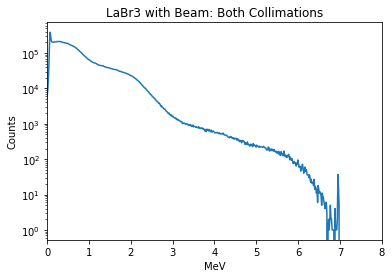

7165.965132740625


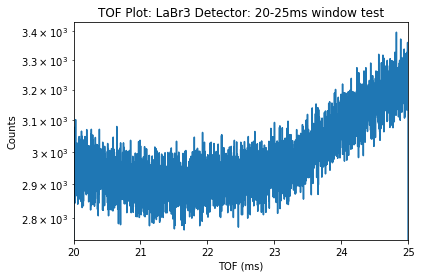

In [16]:
plt.plot(enerHistBins[:-1] * m + b, enerHists[0])
plt.title('LaBr3 with Beam: Both Collimations')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlabel('MeV')
plt.xlim(0, 8)
plt.show()
print((6.2 - b)/m)

rescaleBins = t0HistBins[:-1] * 5 / 500000 + 20
plt.plot(rescaleBins, t0Hists[0])
plt.title('TOF Plot: LaBr3 Detector: 20-25ms window test')
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(20, 25)
plt.show()


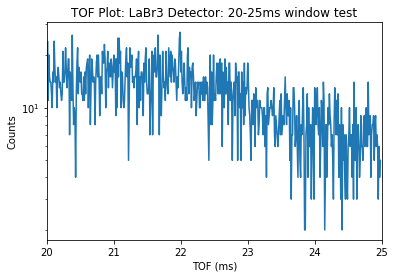

In [27]:
#put a cut on the energies included in this TOF plot
enerCutLow = 3 #energy cut in MeV
pixel = 1
cutT0s = []
for i in range(len(rawPixelValsEner[pixel])):
    if rawPixelValsEner[pixel][i] * m + b > enerCutLow:
        cutT0s.append(rawPixelValsT0[pixel][i])
bins = np.arange(0, 500000, 1000)
t0Hist, bins = np.histogram(cutT0s, bins = bins)
plt.plot(bins[:-1] * 5 / 500000 + 20, t0Hist)
plt.title('TOF Plot: LaBr3 Detector: 20-25ms window test')
plt.xlabel('TOF (ms)')
plt.ylabel('Counts')
plt.yscale('log')
plt.xlim(20, 25)
plt.show()

In [10]:
t0Hists = []
rawPixelValsT0 = []
t0HistBins = np.arange(0,500000, 50)
for pixel in pixelList:
    thisPixel = []
    for res in results: #iterate over each result
        pixelRes = res[0][pixel] #grab the right pixel, the first 0 means grab the energy/timing information
        for wave in pixelRes: #iterate over each waveform
            for a in wave:
                if a != []:
                    thisPixel.append(a[0])
    rawPixelValsT0.append(thisPixel)
    t0Hist, bins = np.histogram(thisPixel, bins = t0HistBins)
    t0Hists.append(t0Hist)

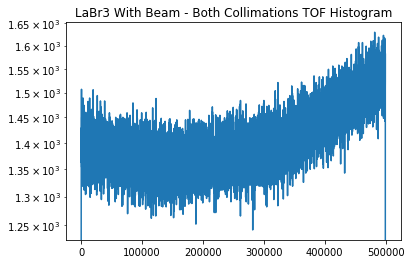

In [11]:
bins = np.arange(0,500000, 50)
hist, bins = np.histogram(rawPixelValsT0, bins=t0HistBins)

plt.plot(bins[:-1], hist)
plt.title(runName + ' TOF Histogram')
plt.yscale('log')
plt.show()

In [29]:
def grabMatchingIndexLoc(array, index):
    locs = np.where(array == index)
    return locs[0][0]

def fitFunc(x, mu, sig, a, b, c):
    return a * np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + b * x + c


def fitPeak(hist, bins, peakLocGuess, fitwidth):
    #grab a piece of the array around this point
    #figure out where the guess location is in the array
    index = grabMatchingIndexLoc(bins, peakLocGuess)
    window = hist[index - fitwidth:index+fitwidth]
    windowbins = bins[index-fitwidth:index+fitwidth]
    guess = [peakLocGuess, 25, np.max(window), 0, np.min(window)]
    popt, pcov = optimize.curve_fit(fitFunc, windowbins, window, p0=guess)
    plt.plot(windowbins, window)
    print(popt)
    plt.plot(windowbins, fitFunc(windowbins, *popt))
    plt.show()
    return popt

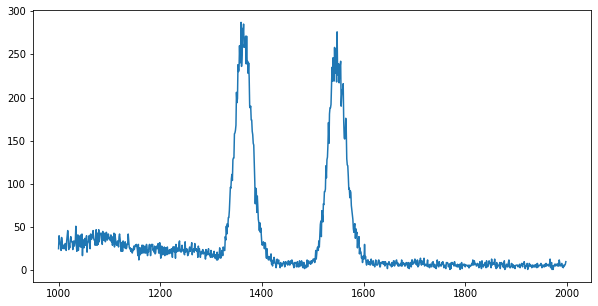

[ 1.36405200e+03  1.60151433e+01  2.56375209e+02 -7.19397228e-02
  1.12368012e+02]


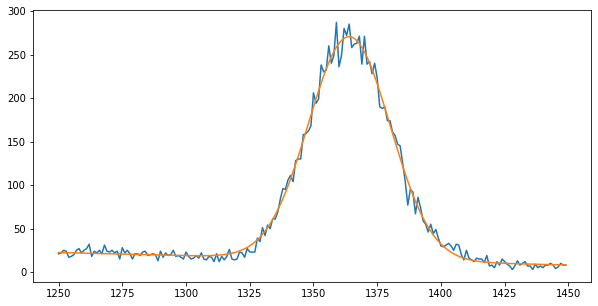

[ 1.54787997e+03  1.73256340e+01  2.35824548e+02  2.05740287e-02
 -2.35374889e+01]


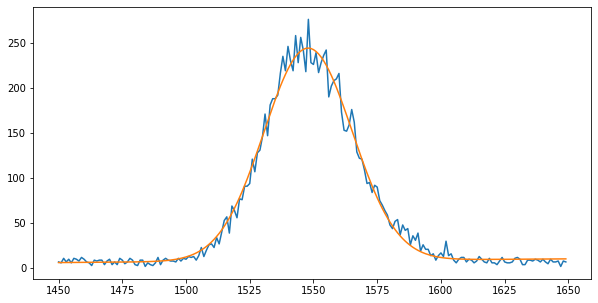

[ 1.36405200e+03  1.60151433e+01  2.56375209e+02 -7.19397228e-02
  1.12368012e+02]
[ 1.54787997e+03  1.73256340e+01  2.35824548e+02  2.05740287e-02
 -2.35374889e+01]


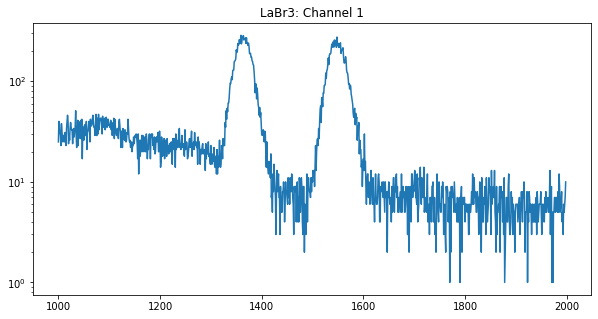

In [30]:
pixelToFit = 0
name = pixelNames[pixelToFit]
rawVals = rawPixelVals[pixelToFit]
bins = np.arange(1000,2000)
hist, bins = np.histogram(rawVals, bins=bins)
plt.plot(bins[:-1], hist)
plt.show()

peak1 = fitPeak(hist, bins, 1350, 100)
peak2 = fitPeak(hist, bins, 1550, 100)
print(peak1)
print(peak2)

plt.plot(bins[:-1], hist)
plt.title(name)
plt.yscale('log')
plt.show()





In [31]:
dataPointsX = [peak1[0], peak2[0]]
dataPointsY = [1.173240, 1.332508]
m, b = np.polyfit(dataPointsX, dataPointsY, 1)
print(m, b)

0.0008663969773644441 -0.00857053090547447


In [32]:
def atClosest(xbins, ybins, xval):
    test = xbins - xval
    test = np.abs(test)
    argmin = np.argmin(test)
    return ybins[argmin-1]

0.03260735870067714
0.03527556083553477


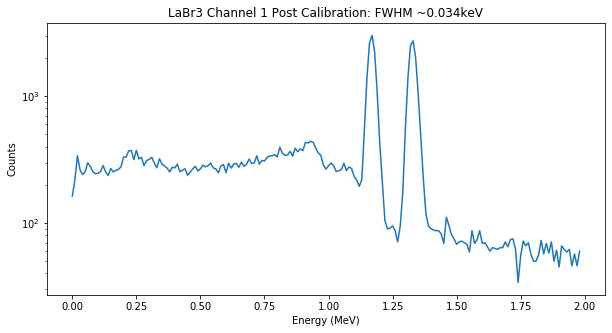

In [36]:
rcParams['figure.figsize'] = 10, 5

y, x = np.histogram(np.array(rawVals) * m + b, bins = np.arange(0, 2, 0.01))
x = x[:-1]
print(peak1[1]*m * 2.35)
print(peak2[1]*m * 2.35)
fwhm = np.mean([peak1[1]*m * 2.35, peak2[1]*m * 2.35])
plt.plot(x, y)
plt.title('LaBr3 Channel 1 Post Calibration: FWHM ~' +str(round(fwhm, 3))+'keV')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.yscale('log')
plt.savefig('LaBr3 Spectrum.png')
plt.show()